## Coursera Capstone Project - Battle of the Neighbourhoods

### Notebook with code

In [173]:
##Importing all required libraries

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim
import folium

import requests

import json
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


In [2]:
##Load raw neighbourhood data for NYC
with open(r'Downloads/nyu-2451-34572-geojson.json') as f:
    nyc_data = json.load(f)
    print(nyc_data)

{'type': 'FeatureCollection', 'totalFeatures': 306, 'features': [{'type': 'Feature', 'id': 'nyu_2451_34572.1', 'geometry': {'type': 'Point', 'coordinates': [-73.84720052054902, 40.89470517661]}, 'geometry_name': 'geom', 'properties': {'name': 'Wakefield', 'stacked': 1, 'annoline1': 'Wakefield', 'annoline2': None, 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.84720052054902, 40.89470517661, -73.84720052054902, 40.89470517661]}}, {'type': 'Feature', 'id': 'nyu_2451_34572.2', 'geometry': {'type': 'Point', 'coordinates': [-73.82993910812398, 40.87429419303012]}, 'geometry_name': 'geom', 'properties': {'name': 'Co-op City', 'stacked': 2, 'annoline1': 'Co-op', 'annoline2': 'City', 'annoline3': None, 'annoangle': 0.0, 'borough': 'Bronx', 'bbox': [-73.82993910812398, 40.87429419303012, -73.82993910812398, 40.87429419303012]}}, {'type': 'Feature', 'id': 'nyu_2451_34572.3', 'geometry': {'type': 'Point', 'coordinates': [-73.82780644716412, 40.887555677350775]}, 'geometry_n

In [3]:
##Convert raw neighbourhood data for NYC into python dataframe
##pick relevant neighbourhood data
neighbourhood_data = nyc_data['features']

##create empty dataframe
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude']
neighbourhoods = pd.DataFrame(columns = column_names)

##Fill dataframe one row at a time
for data in neighbourhood_data:
    borough = neighbourhood_name = data['properties']['borough'] 
    neighbourhood_name = data['properties']['name']
        
    neighbourhood_latlon = data['geometry']['coordinates']
    neighbourhood_lat = neighbourhood_latlon[1]
    neighbourhood_lon = neighbourhood_latlon[0]
    
    neighbourhoods = neighbourhoods.append({'Borough': borough,
                                          'Neighbourhood': neighbourhood_name,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)
neighbourhoods.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
##Examine the number of boroughs and neighbourhoods
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(neighbourhoods['Borough'].unique()),
        neighbourhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighbourhoods.


In [5]:
##Use geopy library to get latitude and longitude values for NYC
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [225]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Borough'], neighbourhoods['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [16]:
##Add neighbourhood-wise average rent data to database
##Due to issues with web scraping - "Error 403: Forbidden", the rent daat table was copied into a csv file and loaded from there
rent_table = pd.read_csv(r'Downloads/nyc_rent_data.csv', header = 1)
rent_table.drop(['Unnamed: 0','Unnamed: 6'], axis =1, inplace = True)
rent_table.head()

,Neighborhood,Studio,1BR,2BR,Budget
0,Alphabet City,NaN,"$3,095","$3,645",Average
1,Astoria,NaN,"$2,658","$3,456",Average
2,Bay Ridge,NaN,"$1,800","$2,200",Cheap
3,Boerum Hill,NaN,"$3,314","$4,000",Pricey
4,Brooklyn,"$2,604","$3,216","$3,500",Pricey


In [17]:
##Check number of neighbourhoods for which rent data is available
print('Rent data is available for {} neighbourhoods.'.format(rent_table.shape[0]))

Rent data is available for 67 neighbourhoods.


In [18]:
##Rent values for Studio and 2BR to be dropped, since there are many NaN values. Rent for 1BR to be used as average rent
##Merging average rent values with neighbourhood data
#neighbourhoods.drop(['index'], axis = 1, inplace = True)
rent_table.drop(['Studio','2BR','Budget'], axis = 1, inplace = True)
rent_table.rename(columns = {'Neighborhood': 'Neighbourhood'}, inplace = True)
neighbourhoods_new = pd.merge(neighbourhoods, rent_table, on='Neighbourhood')
neighbourhoods_new.drop_duplicates(subset = "Neighbourhood", inplace = True)
neighbourhoods_new.reset_index(drop = True, inplace = True)
neighbourhoods_new.head()

,Borough,Neighbourhood,Latitude,Longitude,1BR
0,Brooklyn,Bay Ridge,40.625801,-74.030621,"$1,800"
1,Brooklyn,Williamsburg,40.707144,-73.958115,"$3,250"
2,Brooklyn,Bushwick,40.698116,-73.925258,"$2,391"
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,"$2,400"
4,Brooklyn,Gowanus,40.673931,-73.994441,"$3,198"


In [27]:
##Check number of neighbourhoods having both latlong and rent information 
print('All data is available for {} neighbourhoods.'.format(neighbourhoods_new.shape[0]))

All data is available for 38 neighbourhoods.


In [31]:
##Only the above 38 neighbourhoods for which all data is available to be used for further analysis

##Data cleaning 
neighbourhoods_new.rename(columns = {'1BR':'Average_Rent'},inplace = True)
neighbourhoods_new['Average_Rent'] = neighbourhoods_new['Average_Rent'].str.lstrip('$')
neighbourhoods_new['Average_Rent'] = neighbourhoods_new['Average_Rent'].str.replace(',', '')
neighbourhoods_new['Average_Rent'] = neighbourhoods_new['Average_Rent'].astype(int)
neighbourhoods_new.head()

,Borough,Neighbourhood,Latitude,Longitude,Average_Rent
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1800
1,Brooklyn,Williamsburg,40.707144,-73.958115,3250
2,Brooklyn,Bushwick,40.698116,-73.925258,2391
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,2400
4,Brooklyn,Gowanus,40.673931,-73.994441,3198


In [32]:
neighbourhoods_new['Neighbourhood']

0                     Bay Ridge
1                  Williamsburg
2                      Bushwick
3               Carroll Gardens
4                       Gowanus
5                   Fort Greene
6                    Park Slope
7                  Clinton Hill
8                   Boerum Hill
9     Prospect Lefferts Gardens
10                   North Side
11           Washington Heights
12                       Inwood
13             Hamilton Heights
14                  East Harlem
15              Upper East Side
16                    Yorkville
17              Upper West Side
18               Lincoln Square
19                  Murray Hill
20                      Chelsea
21            Greenwich Village
22                 East Village
23              Lower East Side
24                      Tribeca
25                 West Village
26             Manhattan Valley
27          Morningside Heights
28           Financial District
29                      Astoria
30              Jackson Heights
31      

In [37]:
##Add neighbourhood-wise crime data to database
##Since crime data was available only by manually searching for each neighbourhood, a csv table with required information for specific neighbourhoods was created
##Crime rating, present in albhabetic grading system, was manually converted to a relative numeric rating
crime_table = pd.read_csv(r'Downloads/nyc_crime_rate.csv', header = 1)
crime_table.drop(['Unnamed: 0','Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis =1, inplace = True)
crime_table.head()

,Neighbourhood,Crime Grade,Numeric Crime Grade
0,Bay Ridge,C+,2.0
1,Williamsburg,C+,2.0
2,Bushwick,C,1.0
3,Carroll Gardens,B-,3.0
4,Gowanus,B-,3.0


In [44]:
#Drop neighbourhoods that have no value for crime rates
crime_table.dropna(subset= ['Crime Grade'], inplace = True)
crime_table.head()

,Neighbourhood,Crime Grade,Numeric Crime Grade
0,Bay Ridge,C+,2.0
1,Williamsburg,C+,2.0
2,Bushwick,C,1.0
3,Carroll Gardens,B-,3.0
4,Gowanus,B-,3.0


In [45]:
##Check number of neighbourhoods for which crime data is available
print('Crime data is available for {} of the neighbourhoods in our dataset.'.format(crime_table.shape[0]))

Crime data is available for 32 of the neighbourhoods in our dataset.


In [48]:
#Merge crime data with other neighbourhood data
#Remove alphabetic crime data
neighbourhoods_final = pd.merge(neighbourhoods_new, crime_table, on='Neighbourhood')
neighbourhoods_final.drop(['Crime Grade'], axis = 1, inplace = True)
neighbourhoods_final.drop_duplicates(subset = "Neighbourhood", inplace = True)
neighbourhoods_final.reset_index(drop = True, inplace = True)
neighbourhoods_final.rename(columns = {'Numeric Crime Grade': 'Numeric_crime_grade'}, inplace = True)
neighbourhoods_final.head()

,Borough,Neighbourhood,Latitude,Longitude,Average_Rent,Numeric_crime_grade
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1800,2.0
1,Brooklyn,Williamsburg,40.707144,-73.958115,3250,2.0
2,Brooklyn,Bushwick,40.698116,-73.925258,2391,1.0
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,2400,3.0
4,Brooklyn,Gowanus,40.673931,-73.994441,3198,3.0


In [49]:
neighbourhoods_final.shape

(32, 6)

In [50]:
#define foursquare credentials and versions
CLIENT_ID = 'SBXRHKUFBWA0OG2QXSDNEYFCYUDAZBZH1QDOZ3BRUK4MB0KS' # your Foursquare ID
CLIENT_SECRET = 'RGRKYB2JOTPMVN4WGUJJJ121BVFIEJ10JGAPUNSGNQMEWJFV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SBXRHKUFBWA0OG2QXSDNEYFCYUDAZBZH1QDOZ3BRUK4MB0KS
CLIENT_SECRET:RGRKYB2JOTPMVN4WGUJJJ121BVFIEJ10JGAPUNSGNQMEWJFV


In [51]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [56]:
#Function to explore neighbourhoods in NYC
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [57]:
#Code to explore each neighbourhood in NYC using above code
LIMIT = 100
nyc_venues = getNearbyVenues(names=neighbourhoods_final['Neighbourhood'],
                                   latitudes=neighbourhoods_final['Latitude'],
                                   longitudes=neighbourhoods_final['Longitude']
                                  )

Bay Ridge
Williamsburg
Bushwick
Carroll Gardens
Gowanus
Fort Greene
Park Slope
Clinton Hill
Boerum Hill
Prospect Lefferts Gardens
Washington Heights
Inwood
East Harlem
Upper East Side
Yorkville
Upper West Side
Lincoln Square
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
West Village
Morningside Heights
Financial District
Astoria
Jackson Heights
Long Island City
Sunnyside
Rego Park
Woodhaven


In [58]:
nyc_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place


In [60]:
nyc_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Astoria,100,100,100,100,100,100
Bay Ridge,84,84,84,84,84,84
Boerum Hill,89,89,89,89,89,89
Bushwick,73,73,73,73,73,73
Carroll Gardens,100,100,100,100,100,100
Chelsea,100,100,100,100,100,100
Clinton Hill,95,95,95,95,95,95
East Harlem,46,46,46,46,46,46
East Village,100,100,100,100,100,100


In [63]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# add neighborhood column back to dataframe
nyc_onehot["Neighbourhood"] = nyc_venues['Neighbourhood']

# move neighborhood column to the first column
neighbourhood = nyc_onehot['Neighbourhood']
nyc_onehot.drop(labels=['Neighbourhood'], axis = 1, inplace = True)
nyc_onehot.insert(0,'Neighbourhood', neighbourhood)
nyc_onehot.head()

,Neighbourhood,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
#Group rows by neighbourhood and take mean frwquency of occurence of each neighbourhood
nyc_grouped = nyc_onehot.groupby('Neighbourhood').mean().reset_index()
nyc_grouped.head()

,Neighbourhood,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,...,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Astoria,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.00,0.010000,0.00,0.00,0.000000
1,Bay Ridge,0.0,0.035714,0.000000,0.0,0.0,0.000000,0.0,0.011905,0.0,...,0.00,0.011905,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.000000
2,Boerum Hill,0.0,0.011236,0.011236,0.0,0.0,0.011236,0.0,0.022472,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.00,0.011236,0.00,0.00,0.022472
3,Bushwick,0.0,0.013699,0.000000,0.0,0.0,0.013699,0.0,0.000000,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.000000
4,Carroll Gardens,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.010000,0.0,...,0.01,0.000000,0.0,0.0,0.0,0.02,0.030000,0.01,0.01,0.000000


In [71]:
#Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [73]:
#Dataframe to display top 10 venues in each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = nyc_grouped['Neighbourhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Mediterranean Restaurant,Bakery,Food Truck,Salon / Barbershop,Pub
1,Bay Ridge,Italian Restaurant,Spa,Pizza Place,American Restaurant,Bar,Greek Restaurant,Diner,Hookah Bar,Playground,Sushi Restaurant
2,Boerum Hill,Coffee Shop,Dance Studio,Sandwich Place,Bar,French Restaurant,Deli / Bodega,Spa,Furniture / Home Store,Middle Eastern Restaurant,Martial Arts Dojo
3,Bushwick,Bar,Coffee Shop,Mexican Restaurant,Pizza Place,Deli / Bodega,Discount Store,Thrift / Vintage Store,Bakery,Italian Restaurant,Vegetarian / Vegan Restaurant
4,Carroll Gardens,Italian Restaurant,Coffee Shop,Cocktail Bar,Pizza Place,Gym / Fitness Center,Wine Shop,Bar,Bakery,Spa,Thai Restaurant


In [78]:
#Merge venue data with other neighbourhood data
neighbourhoods_nyc = pd.merge(neighbourhoods_final, nyc_grouped, on='Neighbourhood')
neighbourhoods_nyc.head()

,Borough,Neighbourhood,Latitude,Longitude,Average_Rent,Numeric_crime_grade,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Brooklyn,Bay Ridge,40.625801,-74.030621,1800,2.0,0.0,0.035714,0.0,0.0,...,0.00,0.011905,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000
1,Brooklyn,Williamsburg,40.707144,-73.958115,3250,2.0,0.0,0.000000,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.030303,0.000000,0.00,0.00,0.030303
2,Brooklyn,Bushwick,40.698116,-73.925258,2391,1.0,0.0,0.013699,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,2400,3.0,0.0,0.000000,0.0,0.0,...,0.01,0.000000,0.0,0.0,0.0,0.020000,0.030000,0.01,0.01,0.000000
4,Brooklyn,Gowanus,40.673931,-73.994441,3198,3.0,0.0,0.014493,0.0,0.0,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.028986,0.00,0.00,0.014493


In [79]:
#Dataframe to run k-means clustering
neighbourhoods_nyc_clustering = neighbourhoods_nyc.drop(['Borough','Neighbourhood','Latitude','Longitude'], axis = 1)
neighbourhoods_nyc_clustering.head()

,Average_Rent,Numeric_crime_grade,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1800,2.0,0.0,0.035714,0.0,0.0,0.000000,0.000000,0.0,0.011905,...,0.00,0.011905,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000
1,3250,2.0,0.0,0.000000,0.0,0.0,0.000000,0.030303,0.0,0.000000,...,0.00,0.000000,0.0,0.0,0.0,0.030303,0.000000,0.00,0.00,0.030303
2,2391,1.0,0.0,0.013699,0.0,0.0,0.000000,0.013699,0.0,0.000000,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000
3,2400,3.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.010000,...,0.01,0.000000,0.0,0.0,0.0,0.020000,0.030000,0.01,0.01,0.000000
4,3198,3.0,0.0,0.014493,0.0,0.0,0.014493,0.028986,0.0,0.000000,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.028986,0.00,0.00,0.014493


In [174]:
#Preprocessing data for clustering
X = MinMaxScaler().fit_transform(neighbourhoods_nyc_clustering)

In [175]:
X[0:5]

array([[0.03296703, 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.67032967, 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.95959596],
       [0.29274725, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2967033 , 0.66666667, 0.        , ..., 1.        , 0.59      ,
        0.        ],
       [0.64747253, 0.66666667, 0.        , ..., 0.        , 0.        ,
        0.4589372 ]])

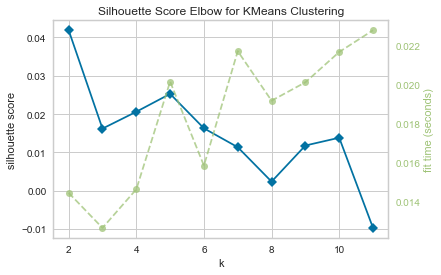

In [194]:
#Visualising the clustering accuracy for different values of K using silhouette method
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k = (2,12), metric = 'silhouette')
visualizer.fit(X)
visualizer.poof()

In [206]:
#K-means clustering to create 2 clusters
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0], dtype=int32)

In [82]:
#neighborhoods_venues_sorted.drop(labels=['Cluster Labels'], axis = 1, inplace = True)

In [207]:
#Dataframe that includes cluster as well as top 10 venues for each cluster
nyc_merged = pd.merge(neighbourhoods_final, neighborhoods_venues_sorted, on='Neighbourhood')

# add clustering labels
nyc_merged.insert(0, 'Cluster Labels', kmeans.labels_)
nyc_merged.head()

,Cluster Labels,Borough,Neighbourhood,Latitude,Longitude,Average_Rent,Numeric_crime_grade,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Brooklyn,Bay Ridge,40.625801,-74.030621,1800,2.0,Italian Restaurant,Spa,Pizza Place,American Restaurant,Bar,Greek Restaurant,Diner,Hookah Bar,Playground,Sushi Restaurant
1,1,Brooklyn,Williamsburg,40.707144,-73.958115,3250,2.0,Bar,Bagel Shop,Coffee Shop,Yoga Studio,Burger Joint,Korean Restaurant,Taco Place,Latin American Restaurant,Steakhouse,Breakfast Spot
2,0,Brooklyn,Bushwick,40.698116,-73.925258,2391,1.0,Bar,Coffee Shop,Mexican Restaurant,Pizza Place,Deli / Bodega,Discount Store,Thrift / Vintage Store,Bakery,Italian Restaurant,Vegetarian / Vegan Restaurant
3,1,Brooklyn,Carroll Gardens,40.680540,-73.994654,2400,3.0,Italian Restaurant,Coffee Shop,Cocktail Bar,Pizza Place,Gym / Fitness Center,Wine Shop,Bar,Bakery,Spa,Thai Restaurant
4,0,Brooklyn,Gowanus,40.673931,-73.994441,3198,3.0,Bar,Furniture / Home Store,Italian Restaurant,Gym / Fitness Center,Mexican Restaurant,Coffee Shop,Wine Shop,Hardware Store,Deli / Bodega,Rental Car Location


In [208]:
#Visualise clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighbourhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [209]:
#Exploring cluster 0
nyc_cluster0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0]
nyc_cluster0

,Cluster Labels,Borough,Neighbourhood,Latitude,Longitude,Average_Rent,Numeric_crime_grade,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,0,Brooklyn,Bushwick,40.698116,-73.925258,2391,1.0,Bar,Coffee Shop,Mexican Restaurant,Pizza Place,Deli / Bodega,Discount Store,Thrift / Vintage Store,Bakery,Italian Restaurant,Vegetarian / Vegan Restaurant
4,0,Brooklyn,Gowanus,40.673931,-73.994441,3198,3.0,Bar,Furniture / Home Store,Italian Restaurant,Gym / Fitness Center,Mexican Restaurant,Coffee Shop,Wine Shop,Hardware Store,Deli / Bodega,Rental Car Location
9,0,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,2700,2.0,Café,Bakery,Pizza Place,Caribbean Restaurant,Supermarket,Wine Shop,Liquor Store,Ice Cream Shop,Indian Restaurant,Sushi Restaurant
10,0,Manhattan,Washington Heights,40.851903,-73.936900,1825,2.0,Café,Grocery Store,Bakery,Mobile Phone Shop,Latin American Restaurant,Chinese Restaurant,Sandwich Place,Supplement Shop,Supermarket,Coffee Shop
11,0,Manhattan,Inwood,40.867684,-73.921210,1750,2.0,Mexican Restaurant,Café,Pizza Place,Lounge,American Restaurant,Chinese Restaurant,Wine Bar,Pharmacy,Spanish Restaurant,Deli / Bodega
12,0,Manhattan,East Harlem,40.792249,-73.944182,2473,1.0,Mexican Restaurant,Bakery,Deli / Bodega,Coffee Shop,Thai Restaurant,Latin American Restaurant,Park,Cuban Restaurant,Taco Place,Liquor Store
23,0,Manhattan,West Village,40.734434,-74.006180,3600,3.0,Italian Restaurant,New American Restaurant,Cosmetics Shop,American Restaurant,Park,Wine Bar,Cocktail Bar,Coffee Shop,Jazz Club,Bakery
24,0,Manhattan,Morningside Heights,40.808000,-73.963896,2500,3.0,American Restaurant,Bookstore,Coffee Shop,Park,Burger Joint,Sandwich Place,Deli / Bodega,Food Truck,Tennis Court,Pharmacy
27,0,Queens,Jackson Heights,40.751981,-73.882821,1842,2.0,Latin American Restaurant,Peruvian Restaurant,Mobile Phone Shop,South American Restaurant,Bakery,Mexican Restaurant,Spanish Restaurant,Thai Restaurant,Diner,Empanada Restaurant
29,0,Queens,Sunnyside,40.740176,-73.926916,2038,3.0,Pizza Place,Italian Restaurant,South American Restaurant,Bakery,Chinese Restaurant,Coffee Shop,Deli / Bodega,Discount Store,Hotel,Peruvian Restaurant


In [210]:
nyc_cluster0.describe()

,Cluster Labels,Latitude,Longitude,Average_Rent,Numeric_crime_grade
count,12.0,12.000000,12.000000,12.000000,12.000000
mean,0.0,40.749646,-73.931053,2398.916667,2.250000
std,0.0,0.067853,0.047360,599.422670,0.753778
min,0.0,40.658420,-74.006180,1725.000000,1.000000
25%,0.0,40.696059,-73.957148,1837.750000,2.000000
50%,0.0,40.737305,-73.931908,2432.000000,2.000000
75%,0.0,40.796187,-73.911613,2711.250000,3.000000
max,0.0,40.867684,-73.857827,3600.000000,3.000000


In [216]:
#Exploring cluster 1
nyc_cluster1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1]
nyc_cluster1

,Cluster Labels,Borough,Neighbourhood,Latitude,Longitude,Average_Rent,Numeric_crime_grade,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Brooklyn,Bay Ridge,40.625801,-74.030621,1800,2.0,Italian Restaurant,Spa,Pizza Place,American Restaurant,Bar,Greek Restaurant,Diner,Hookah Bar,Playground,Sushi Restaurant
1,1,Brooklyn,Williamsburg,40.707144,-73.958115,3250,2.0,Bar,Bagel Shop,Coffee Shop,Yoga Studio,Burger Joint,Korean Restaurant,Taco Place,Latin American Restaurant,Steakhouse,Breakfast Spot
3,1,Brooklyn,Carroll Gardens,40.680540,-73.994654,2400,3.0,Italian Restaurant,Coffee Shop,Cocktail Bar,Pizza Place,Gym / Fitness Center,Wine Shop,Bar,Bakery,Spa,Thai Restaurant
5,1,Brooklyn,Fort Greene,40.688527,-73.972906,3365,1.0,Italian Restaurant,Flower Shop,Coffee Shop,Yoga Studio,Theater,French Restaurant,Mexican Restaurant,New American Restaurant,Opera House,Performing Arts Venue
6,1,Brooklyn,Park Slope,40.672321,-73.977050,2750,3.0,American Restaurant,Coffee Shop,Burger Joint,Pizza Place,Italian Restaurant,Bakery,Caribbean Restaurant,Bagel Shop,Japanese Restaurant,Furniture / Home Store
7,1,Brooklyn,Clinton Hill,40.693229,-73.967843,2689,3.0,Italian Restaurant,Chinese Restaurant,Pizza Place,Mexican Restaurant,Yoga Studio,Restaurant,Japanese Restaurant,Thai Restaurant,Indian Restaurant,Wine Shop
8,1,Brooklyn,Boerum Hill,40.685683,-73.983748,3314,2.0,Coffee Shop,Dance Studio,Sandwich Place,Bar,French Restaurant,Deli / Bodega,Spa,Furniture / Home Store,Middle Eastern Restaurant,Martial Arts Dojo
13,1,Manhattan,Upper East Side,40.775639,-73.960508,2800,3.0,Italian Restaurant,Exhibit,Art Gallery,Bakery,Coffee Shop,Gym / Fitness Center,Spa,Hotel,French Restaurant,Juice Bar
14,1,Manhattan,Yorkville,40.775930,-73.947118,2800,3.0,Italian Restaurant,Coffee Shop,Bar,Gym,Pizza Place,Deli / Bodega,Sushi Restaurant,Japanese Restaurant,Wine Shop,Mexican Restaurant
15,1,Manhattan,Upper West Side,40.787658,-73.977059,3500,3.0,Italian Restaurant,Coffee Shop,Wine Bar,Bakery,Vegetarian / Vegan Restaurant,Bar,Indian Restaurant,Pub,Café,Middle Eastern Restaurant


In [217]:
nyc_cluster1.describe()

,Cluster Labels,Latitude,Longitude,Average_Rent,Numeric_crime_grade
count,20.0,20.000000,20.000000,20.000000,20.00000
mean,1.0,40.723914,-73.978782,3105.850000,2.65000
std,0.0,0.042328,0.026727,533.940296,0.67082
min,1.0,40.625801,-74.030621,1800.000000,1.00000
25%,1.0,40.692054,-73.995969,2787.500000,2.00000
50%,1.0,40.724227,-73.979611,3225.000000,3.00000
75%,1.0,40.754790,-73.966009,3398.750000,3.00000
max,1.0,40.787658,-73.915654,4000.000000,4.00000


In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Number of neighbourhoods')

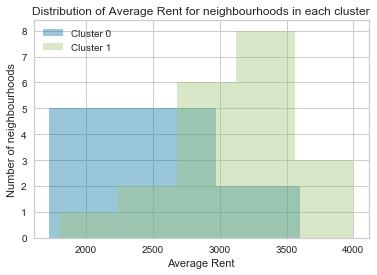

In [223]:
#Plot distribution of average rent for neighbourhoods in the two clusters
sns.distplot(nyc_cluster0['Average_Rent'], kde = False, label = 'Cluster 0')
sns.distplot(nyc_cluster1['Average_Rent'], kde = False, label = 'Cluster 1')
plt.legend()
plt.title('Distribution of Average Rent for neighbourhoods in each cluster')
plt.xlabel('Average Rent')
plt.ylabel('Number of neighbourhoods')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Number of neighbourhoods')

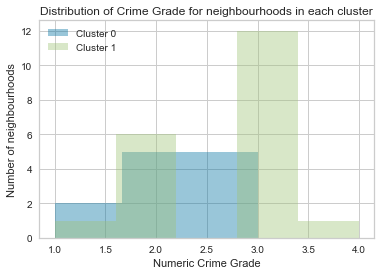

In [224]:
#Plot distribution of crime grade for neighbourhoods in the two clusters
sns.distplot(nyc_cluster0['Numeric_crime_grade'], kde = False, label = 'Cluster 0')
sns.distplot(nyc_cluster1['Numeric_crime_grade'], kde = False, label = 'Cluster 1')
plt.legend()
plt.title('Distribution of Crime Grade for neighbourhoods in each cluster')
plt.xlabel('Numeric Crime Grade')
plt.ylabel('Number of neighbourhoods')

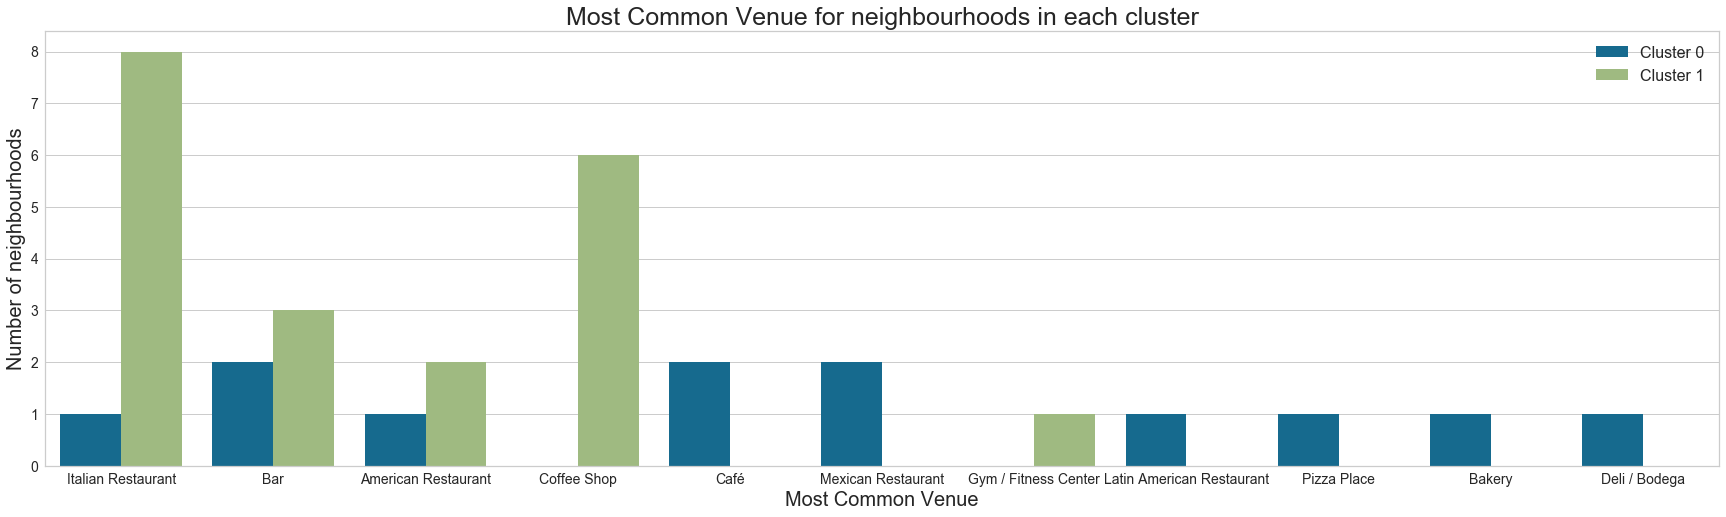

In [251]:
#Plot distribution of 1st most common venue in each cluster
plt.figure(figsize=(30,8))
sns.countplot(x = "1st Most Common Venue", hue = "Cluster Labels", data = nyc_merged )
plt.legend(loc = 'upper right', labels = ['Cluster 0', 'Cluster 1'], fontsize = 16)
plt.title('Most Common Venue for neighbourhoods in each cluster', fontsize = 25)
plt.xlabel('Most Common Venue', fontsize = 20)
plt.ylabel('Number of neighbourhoods', fontsize = 20)
plt.tick_params(labelsize = 14)